# Programming Assignment

### 1. Libraries

In [1]:
import re
import networkx as nx


### 2. Read the input and check for a valid regex

In [2]:
# Read the input from the user 
input_regex = r"a?(a|b)*?b"

# Check on the input is a valid regex

re.compile(input_regex)


re.compile(r'a?(a|b)*?b', re.UNICODE)

### 3. Preprocessing 
<P>Remove square brackets and replace it with <b>OR</b>ing</P>
<P>Add concatenation character</P>


In [3]:
def find_square_bracket_ranges(regex):
    ranges = []
    start = -1
    for i, char in enumerate(regex):
        if char == "[":
            if start == -1:
                start = i + 1
        elif char == "]":
            if start != -1:
                ranges.append((start, i))
                start = -1
                
    return ranges


def split_ranges(s: str):
    expanded_string = ""
    it = iter(enumerate(s))
    for i, char in it:
        if i + 1 != len(s) and s[i + 1] == "-":
            temp_str = ""
            start_symbol = char
            end_symbol = s[i + 2]
            ascii_range = ord(end_symbol) - ord(start_symbol) + 1
            for i in range(ascii_range):
                temp_str += chr(ord(start_symbol) + i) + "|"
            expanded_string += temp_str
            [next(it) for _ in range(2)]
        elif char != "-":
            expanded_string += char + "|"

    return expanded_string[:-1]


CONCAT_SYMBOL = "#"


def insert_concat_symbol_2(regex):
    result = ""
    inside_brackets = False
    for i in range(len(regex)):
        if regex[i] == "[":
            inside_brackets = True
        elif regex[i] == "]":
            inside_brackets = False

        if (
            not inside_brackets
            and i < len(regex) - 1
            and regex[i] != "("
            # and regex[i + 1] != "("
            # and regex[i] != ")"
            and regex[i + 1] != ")"
            and regex[i + 1] not in ["?", ".", "*", "|", "+"]
            and regex[i] not in ["?", ".", "*", "|", "+"]
        ):
            result += regex[i] + CONCAT_SYMBOL
        else:
            result += regex[i]
    return result

def preprocess_regex_2(regex):
    # Preprocess ranges
    ranges = find_square_bracket_ranges(regex)
    expanded_ranges = []
    for start, end in ranges:
        expanded_ranges.append(split_ranges(regex[start:end]))
    # Replace ranges with expanded ranges
    inside_square_brackets = False
    inserted_expanded_range = False
    bracket_count = 0
    new_regex = ""

    for char in regex:
        if char == "[":
            bracket_count += 1
            inside_square_brackets = True
            new_regex += "("
        elif char == "]":
            inside_square_brackets = False
            inserted_expanded_range = False
            new_regex += ")"
        elif not inside_square_brackets:
            new_regex += char
        elif inside_square_brackets and not inserted_expanded_range:
            new_regex += expanded_ranges[bracket_count - 1]
            inserted_expanded_range = True
    new_regex = insert_concat_symbol_2(new_regex)
    print(new_regex)
    return new_regex


In [4]:

CONCAT_SYMBOL = "#"


def insert_concat_symbol(regex):
    result = ""
    operators = ["?", ".", "*", "|", "+"]
    for i in range(len(regex)):
        if (
            i < len(regex) - 1
            and regex[i + 1] not in operators
            and regex[i] not in operators
            and regex[i] != "("
            and regex[i + 1] != ")"
        ):
            result += regex[i] + CONCAT_SYMBOL
        else:
            result += regex[i]      
    return result


def preprocess_regex(regex):
    new_regex = ""
    skip = -1
    for i, char in enumerate(regex):
        if i <= skip:
            continue
        if char == "[":
            end = regex.find(']', i)  # Find the end of the bracketed expression
            if end == -1:
                raise ValueError('Mismatched brackets')  # Raise an error if there is no matching close bracket
            # Handle ranges within the bracketed expression
            bracketed = regex[i+1:end]
            if '-' in bracketed:
                new_bracketed = ""
                splited_bracketed = bracketed.split('-')
                for j, _ in enumerate(splited_bracketed):
                    if j + 1 != len(splited_bracketed):
                        range_start = splited_bracketed[j]
                        range_end = splited_bracketed[j + 1]
                        ascii_range = ord(range_end[0]) - ord(range_start[-1])
                        range_symbols = ""
                        for k in range(ascii_range):
                            if k != 0:
                                range_symbols += chr(ord(range_start[-1]) + k) + "|"
                        if j == 0:
                            len_range_start = len(range_start)
                            for k, ch in enumerate(range_start):
                                if k == len_range_start - 1:
                                    new_bracketed += ch
                                    continue
                                new_bracketed += ch + "|"
                        new_bracketed += "|" + range_symbols 
                        for k, ch in enumerate(range_end):
                            if k == 0:
                                new_bracketed += ch
                                continue
                            new_bracketed += "|" + ch
            new_regex += f"({new_bracketed})"  # Treat the entire bracketed expression as a single character
            skip = end      # Skip to the end of the bracketed expression
        else:
            new_regex += char
    new_regex = insert_concat_symbol(new_regex)        
    print(new_regex)
    return new_regex            


### 4. Shunting yard algorithm 
<P>Convert infix regex to postfix regex</P>

In [5]:
def shunting_yard(input_regex):
    # Define precedence
    """
        * : 0 or more repetition
        + : 1 or more repetition
        # : concatenation
        . : Any single character
        | : OR
    """
    precedence = {'*': 5, '+': 4, '?': 3, '.': 2, '|': 1}
    
    precedence = {
    '*': 6,  # 0 or more repetition
    '+': 5,  # 1 or more repetition
    '?': 4,  # optional (exists or not)
    '#': 3,  # concatenation operator
    '.': 2,  # any single character
    '|': 1   # OR operator
    }
    
    # postfix_output queue and operator operator_stack
    postfix_output = []
    operator_stack = []

    # Process each character in the input
    i = 0
    while i < len(input_regex):
        char = input_regex[i]
        if char == '(':
            operator_stack.append(char)
        elif char == ')':
            while operator_stack and operator_stack[-1] != '(':
                postfix_output.append(operator_stack.pop())
            # check operator_stack error if ')' is not have openning '('
            if not operator_stack:
                return None
            operator_stack.pop()  # Remove the '('
        elif char in precedence:
            while operator_stack and operator_stack[-1] in precedence and precedence[char] <= precedence[operator_stack[-1]]:
                postfix_output.append(operator_stack.pop())
            operator_stack.append(char)
        else:
            postfix_output.append(char)
        i += 1

    # Pop remaining operators from the operator_stack to the postfix_output
    while operator_stack:
        # check operator_stack error if there is still '(' in the operator_stack so it won't have a close ')'
        if operator_stack[-1] == '(':
            return None
        postfix_output.append(operator_stack.pop())

    # Return the postfix_output as a string
    return ''.join(postfix_output)


### 5. Convert postfix regex to NFA using thomson's rule

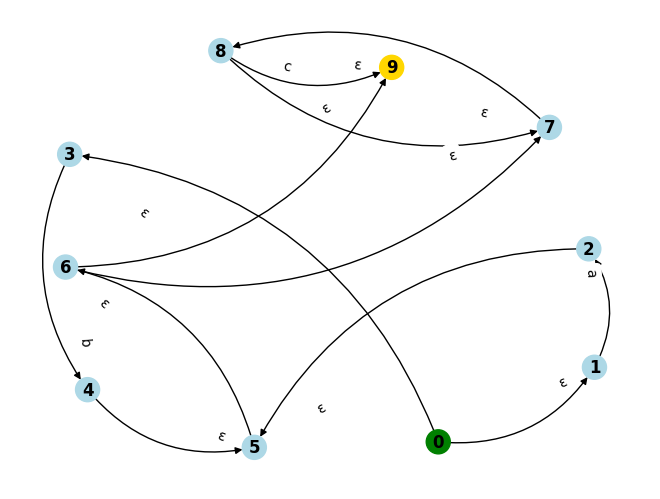

{
  "startingState": "0",
  "0": {
    "isTerminatingState": false,
    "ε": [
      "1",
      "3"
    ]
  },
  "1": {
    "isTerminatingState": false,
    "a": "2"
  },
  "2": {
    "isTerminatingState": false,
    "ε": "5"
  },
  "3": {
    "isTerminatingState": false,
    "b": "4"
  },
  "4": {
    "isTerminatingState": false,
    "ε": "5"
  },
  "5": {
    "isTerminatingState": false,
    "ε": "6"
  },
  "6": {
    "isTerminatingState": false,
    "ε": [
      "7",
      "9"
    ]
  },
  "7": {
    "isTerminatingState": false,
    "c": "8"
  },
  "8": {
    "isTerminatingState": false,
    "ε": [
      "9",
      "7"
    ]
  },
  "9": {
    "isTerminatingState": true
  }
}


In [114]:
import networkx as nx
import matplotlib.pyplot as plt
import json

global state_counter
state_counter = 0

def graph_to_json(G):
    """
    Convert a graph to a JSON structure, supporting multiple transitions for the same input symbol,
    with states and transitions sorted. Assume the starting state is the minimum one
    and the terminating state is the maximum one.
    """
    nodes_sorted = sorted(G.nodes(), key=lambda x: (isinstance(x, int), x))
    starting_state = str(nodes_sorted[0])
    terminating_state = str(nodes_sorted[-1])  
    graph_dict = {"startingState": starting_state}
    
    for node in sorted(G.nodes(), key=lambda x: (isinstance(x, int), x)):
        node_entry = {"isTerminatingState": str(node) == terminating_state}
        
        transitions = {}
        for edge in sorted(G.out_edges(node, data=True), key=lambda e: e[2]['symbol']):
            symbol, target_state = edge[2]['symbol'], edge[1]
            if symbol in transitions:
                transitions[symbol] = transitions[symbol] if isinstance(transitions[symbol], list) else [transitions[symbol]]
                transitions[symbol].append(str(target_state))
            else:
                transitions[symbol] = str(target_state)
        
        node_entry.update({symbol: target if isinstance(target, list) and len(target) > 1 else target[0] if isinstance(target, list) else target 
                           for symbol, target in sorted(transitions.items(), key=lambda item: item[0])})
        
        graph_dict[str(node)] = node_entry

    return json.dumps(graph_dict, indent=2, ensure_ascii=False)

def draw_nfa(G, pos=None):
    """
    Draws the NFA with symbols on the edges and highlights the start node (the one with the minimum state number)
    and the end node (the one with the maximum state number).
    """

    if pos is None:
        pos = nx.spring_layout(G, k=5, iterations=50,)  
    
    if G.nodes():
        start_state = min(G.nodes, key=lambda x: (isinstance(x, int), x))
        end_state = max(G.nodes, key=lambda x: (isinstance(x, int), x))
    else:
        start_state, end_state = None, None

    node_colors = ['lightblue' if node not in [start_state, end_state] else ('green' if node == start_state else 'gold') for node in G.nodes()]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, font_weight='bold', arrows=True, connectionstyle='arc3,rad=0.3')

    edge_labels = {(u, v): d['symbol'] for u, v, d in G.edges(data=True)}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.2 )  

    plt.show()

def increment_nfa_states_by_one(nfa):
    """
    Increments the state (label) of each node in the NFA by 1, including updating the start and end states.
    
    Parameters:
    - nfa: A tuple containing the graph (nfa[0]), start state (nfa[1]), and end state (nfa[2]).
    
    Returns:
    - A tuple of the updated graph, new start state, and new end state.
    """
    G, start_state, end_state = nfa

    if G.number_of_nodes() == 0:
        return nfa  

    mapping = {node: node + 1 for node in G.nodes() if isinstance(node, int)}

    new_start_state = mapping.get(start_state, start_state)
    new_end_state = mapping.get(end_state, end_state)

    G_relabelled = nx.relabel_nodes(G, mapping, copy=True)

    return G_relabelled, new_start_state, new_end_state

def create_basic_nfa(symbol):
    """
    Creates a basic NFA for a single symbol.
    """
    global state_counter

    g = nx.DiGraph()
    start_state = state_counter
    state_counter += 1
    end_state = state_counter
    state_counter += 1
    g.add_node(start_state)
    g.add_node(end_state)
    g.add_edge(start_state, end_state, symbol=symbol)

    return g, start_state, end_state

def concatenate(nfa1, nfa2):
    """
    Concatenates two NFAs by connecting the NFA with the minimum maximum state 
    to the one with the maximum minimum state with an ε-transition.
    """
    g = nx.union(nfa1[0], nfa2[0], rename=(None, None))

    max_state_nfa1 = max(nfa1[0].nodes())
    min_state_nfa2 = min(nfa2[0].nodes())

    if max_state_nfa1 < min_state_nfa2:
        g.add_edge(max_state_nfa1, min_state_nfa2, symbol='ε')
        start_state, end_state = nfa1[1], nfa2[2]
    else:
        g.add_edge(min_state_nfa2, max_state_nfa1, symbol='ε')
        start_state, end_state = nfa2[1], nfa1[2]

    return g, start_state, end_state

def alternate(nfa1, nfa2):
    global state_counter

    new_1 = increment_nfa_states_by_one(nfa1)
    new_2 = increment_nfa_states_by_one(nfa2)
    g = nx.union(new_1[0], new_2[0], rename=(None, None))

    max_1 = max(new_1[0].nodes)
    max_2 = max(new_2[0].nodes)

    max_total = max(max_1,max_2)

    start_state = 0
    end_state = max_total + 1
    state_counter = end_state + 1

    g.add_node(start_state)
    g.add_node(end_state)

    g.add_edge(start_state, new_1[1], symbol='ε')
    g.add_edge(start_state, new_2[1], symbol='ε')

    g.add_edge(new_1[2], end_state, symbol='ε')
    g.add_edge(new_2[2], end_state, symbol='ε')

    return g, start_state, end_state

def kleene_star(nfa):
    """
    Creates an NFA representing the Kleene star operation.
    """
    new_nfa = increment_nfa_states_by_one(nfa)

    g, start_state, end_state = new_nfa
    new_g = nx.DiGraph(g)  
    new_start = min(g.nodes) - 1  
    new_end = max(g.nodes) + 1  

    new_g.add_node(new_start)
    new_g.add_node(new_end)

    new_g.add_edge(new_start, start_state, symbol='ε')  # Start to old start
    new_g.add_edge(end_state, new_end, symbol='ε')  # Old end to new end
    new_g.add_edge(end_state, start_state, symbol='ε')  # Loop back to start
    new_g.add_edge(new_start, new_end, symbol='ε')  # Directly skip the NFA

    return new_g, new_start, new_end

def postfix_to_nfa(postfix):
    """
    Converts postfix regex to NFA using Thomson's algorithm.
    """
    stack = []
    for char in postfix:
        if char not in ['*', '|', '#']: 
            nfa = create_basic_nfa(char)
            stack.append(nfa)
        elif char == '*':  # Kleene star
            nfa = kleene_star(stack.pop())
            stack.append(nfa)
        elif char == '|':  # Alternation
            nfa2 = stack.pop()
            nfa1 = stack.pop()
            nfa = alternate(nfa1, nfa2)
            stack.append(nfa)
        elif char == '#':  # Concatenation
            nfa2 = stack.pop()
            nfa1 = stack.pop()
            nfa = concatenate(nfa1, nfa2)
            stack.append(nfa)
    return stack.pop()

postfix_regex = "ab|c*#"
nfa = postfix_to_nfa(postfix_regex)
draw_nfa(nfa[0])

json_output = graph_to_json(nfa[0])
print(json_output)


### 6. Convert NFA to DFA using subset construction 


### 7. Convert to minimized DFA

### 8. Visualizations Graphiz

### Testing

In [7]:


ff = "(asjnd[0-9])|(h4d2*|33+as449d|[2-9a-z(az)*])"
ss = "BAM[a-dA-Ds7-9](ABC)[x-z]?ABC(a)[a-b](FA)(BC)?"
tt = "a?(a+b)*?b"

# input_rege = preprocess_regex_2(ss)
input_regex = preprocess_regex(tt)


print(shunting_yard(input_regex))



a?(a+b)*?b
aab+*?b?
